# Model retrain

SHAP values show that home-related fixtures are highly influential for the highest rated players. From high-level stats we know that since lockdown the home advantage has substantially diminished. We therefore retrain our model without these features.

Changes from `10. Train final model.ipynb`:
- Removed 2 features: next_gameweek_number_of_home_matches, number_of_home_matches
- Weird bug when re-running original notebook where there are suddenly null rows caused by gameweek 38. A simple drop seems to have resolved this

## 0. Set-up

In [1]:
import os
import getpass
import pickle

import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from s3fs import S3FileSystem
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers, Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, rand, tpe, Trials

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences
from src.visualisation.utils import plot_learning_curve

In [4]:
from src.data.s3_utilities import \
    AWS_ACCESS_KEY_ID, \
    AWS_SECRET_KEY

In [5]:
pd.options.display.max_columns = None

In [6]:
RANDOM_SEED = 3
N_STEPS_IN = 5
N_STEPS_OUT = 5

In [7]:
s3_filesystem = S3FileSystem(
    key=AWS_ACCESS_KEY_ID,
    secret=AWS_SECRET_KEY
)

## 1. Preprocessing

### Load FFS data

In [8]:
ffs_all_data = pq.read_table(
    f"s3://fantasy-football-scout/processed/fantasy_football_scout_final_features_and_total_points.parquet", 
    filesystem=s3_filesystem
).to_pandas()

print(ffs_all_data.shape)
ffs_all_data.head()

(92410, 68)


,Name,Team,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,position,full_name,season,gw,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,name,total_points
0,van Persie,ARS,75.0,0,0,1,0,0,1,0,5,0,FWD,Robin van Persie,2011-2012,1,0,100.0,0,0,0,0,0,0,6,0.0,2.1,71,75,75,0,0,1,0,0,21,0,1,0,0,0,0,0.0,1,100.0,90,3,0,8,0,0,0,0,8,7,0.0,4.6,0.0,0.0,0.0,inf,7,13,0,0.0,1,robin_van persie,2
1,Zamora,QPR,40.0,0,0,2,0,0,1,0,0,0,FWD,Bobby Zamora,2011-2012,1,0,50.0,0,0,0,0,1,0,10,0.0,2.0,59,67,63,0,0,3,0,0,21,0,4,0,3,1,0,0.0,2,50.0,74,1,2,15,0,0,0,0,7,6,0.0,11.5,0.0,0.0,0.0,inf,7,16,0,75.0,1,bobby_zamora,2
2,Gervinho,ARS,0.0,0,0,0,1,1,1,1,4,0,FWD,Gervais Yao Kouassi,2011-2012,1,0,80.0,0,0,0,0,1,0,7,0.0,1.7,79,73,76,1,1,4,0,0,33,0,1,0,0,0,0,0.0,5,80.0,76,1,2,20,0,0,0,0,8,12,0.0,6.7,0.0,38.0,0.0,inf,12,9,0,0.0,1,gervais_yao kouassi,-1
3,Welbeck,MUN,0.0,0,0,0,0,0,0,0,0,0,FWD,Danny Welbeck,2011-2012,1,0,0.0,0,0,1,0,3,0,3,0.0,2.3,68,50,60,0,0,2,1,0,14,0,0,0,0,1,0,66.7,1,0.0,65,2,2,4,0,0,0,0,1,3,0.0,1.2,0.0,0.0,32.5,inf,7,7,0,0.0,0,danny_welbeck,2
4,Torres,CHE,0.0,0,1,2,1,0,1,1,2,0,FWD,Fernando Torres,2011-2012,1,0,55.6,0,0,0,0,6,0,10,0.0,1.4,75,68,70,0,0,4,1,0,43,0,3,0,1,1,0,50.0,9,55.6,89,4,4,31,0,0,0,0,6,9,0.0,9.3,0.0,0.0,89.0,inf,13,17,0,25.0,1,fernando_torres,2


In [9]:
ffs_all_data.drop(columns=['Name', 'full_name'], inplace=True)

### Deal with nulls and inf values

In [10]:
columns_with_inf = []
for col in ffs_all_data.columns:
    if 'inf' in ffs_all_data[col].values:
        print(col)
        print(ffs_all_data[ffs_all_data['Minutes Per xG'] == 'inf'].shape[0] / ffs_all_data.shape[0])
        columns_with_inf.append(col)
        print('\n')

Minutes Per xG
0.8352992100422032




/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


- `Minutes Per xGI` contains inf values. For convenience we will drop this and replace it with `xGI Expected Goal Involvement`

nan

In [11]:
(ffs_all_data == 'nan').sum().sum()

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


0

### Add 0 minute events back into data

FFS data only includes players who played > 0 minutes. Therefore if a player is benched one gameweek then they wouldn't appear in the data although we would like to train our model on these cases.

We therefore create a 'master' DataFrame of all unique names and all possible season and gameweek combinations. We then left join the FFS data and fill in nulls with zeros.

Note: We make sure to only add missing gameweeks for seasons in which the player played in the Premier League.

In [12]:
ffs_all_data['season'].unique()

array(['2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016',
       '2016-2017', '2017-2018', '2018-2019', '2019-2020'], dtype=object)

In [13]:
ffs_data_names = ffs_all_data[['name', 'Team', 'position', 'season']].drop_duplicates()
ffs_data_names['key'] = 1
print(ffs_data_names.shape)
ffs_data_names.head()

(4746, 5)


,name,Team,position,season,key
0,robin_van persie,ARS,FWD,2011-2012,1
1,bobby_zamora,QPR,FWD,2011-2012,1
2,gervais_yao kouassi,ARS,FWD,2011-2012,1
3,danny_welbeck,MUN,FWD,2011-2012,1
4,fernando_torres,CHE,FWD,2011-2012,1


In [14]:
gw_df = pd.DataFrame({'gw': range(1, 39)})
gw_df['key'] = 1
gw_df.head()

,gw,key
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [15]:
all_player_season_gw_df = gw_df.merge(ffs_data_names, on='key')
all_player_season_gw_df.drop('key', axis=1, inplace=True)
all_player_season_gw_df.shape

(180348, 5)

In [16]:
all_player_season_gw_df.head()

,gw,name,Team,position,season
0,1,robin_van persie,ARS,FWD,2011-2012
1,1,bobby_zamora,QPR,FWD,2011-2012
2,1,gervais_yao kouassi,ARS,FWD,2011-2012
3,1,danny_welbeck,MUN,FWD,2011-2012
4,1,fernando_torres,CHE,FWD,2011-2012


In [17]:
all_player_season_gw_df.sort_values(['name', 'season', 'gw'], inplace=True)

In [18]:
all_player_season_gw_df.head()

,gw,name,Team,position,season
822,1,aaron_connolly,BHA,FWD,2019-2020
5568,2,aaron_connolly,BHA,FWD,2019-2020
10314,3,aaron_connolly,BHA,FWD,2019-2020
15060,4,aaron_connolly,BHA,FWD,2019-2020
19806,5,aaron_connolly,BHA,FWD,2019-2020


__Note:__ There is a risk that we have added gameweeks for players who only joined their club mid season. Ideally we should remove these.

In [19]:
mid_season_transfers = pd.read_csv('data/external/mid_season_transfers_2016_to_2019.csv')
print(mid_season_transfers.shape)
mid_season_transfers.head()

(43, 5)


,name,transfer_date,old_team,new_team,season
0,aaron_lennon,2018-01-23,Everton,Burnley,2017-18
1,adlène_guédioura,2017-01-31,Watford,Middlesbrough,2016-17
2,alex_oxlade-chamberlain,2017-08-31,Arsenal,Liverpool,2017-18
3,alexis_sánchez,2018-01-22,Arsenal,Manchester United,2017-18
4,andré_ayew,2018-01-31,West Ham United,Swansea City,2017-18


Our mid season dataset only covers 3 seasons (16/17 to 18/19), does not specify gameweek and only looks at changes between PL clubs. It would take a considerable amount of work to get this information so we accept this slight deficiency in the data. It only adds additional 0 events and hopefully shouldn't impact performance greatly.

In [20]:
ffs_data = all_player_season_gw_df.merge(ffs_all_data, on=['name', 'Team', 'position', 'gw', 'season'], how='left', indicator=True)
print(ffs_data.shape)
ffs_data.head()

(180348, 67)


,gw,name,Team,position,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,_merge
0,1,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,2,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,3,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,4,aaron_connolly,BHA,FWD,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,inf,1.0,1.0,0.0,0.0,0.0,1.0,both
4,5,aaron_connolly,BHA,FWD,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,2.2,0.0,0.0,0.0,42.9,0.0,0.0,0.0,50.0,0.0,1.0,both


In [21]:
ffs_data['_merge'].value_counts()

both          92410
left_only     87938
right_only        0
Name: _merge, dtype: int64

In [22]:
ffs_data.drop(columns='_merge', inplace=True)

In [23]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)
ffs_data.head()

,gw,name,Team,position,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points
0,1,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,aaron_connolly,BHA,FWD,2019-2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,aaron_connolly,BHA,FWD,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,inf,1.0,1.0,0.0,0.0,0.0,1.0
4,5,aaron_connolly,BHA,FWD,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,2.2,0.0,0.0,0.0,42.9,0.0,0.0,0.0,50.0,0.0,1.0


In [24]:
ffs_data.isnull().sum()

gw                               0
name                             0
Team                             0
position                         0
season                           0
                             ...  
Passes - Forward             87938
Saves (Shots Outside Box)    87938
Shot Accuracy                87938
Shots Blocked                87938
total_points                 87938
Length: 66, dtype: int64

In [25]:
# From an offline check the missing entries are 0 minutes players in a given GW. We can therefore fill all missing data points with 0.
ffs_data.fillna(0, inplace=True)

### Position dummies

In [26]:
ffs_data = pd.get_dummies(ffs_data, columns=['position'])

In [27]:
ffs_data.rename(columns={'Team': 'team_name'}, inplace=True)

### Merge fixture and odds data

Merging fixture data also serves another purpose. In the previous step we created _all_ possible gameweek-player combinations. However, due to double gameweeks there are many cases where a player simply would not feature in a given gameweek and in this case we want to remove that player-gameweek for the data. An inner join to fixtures data does this.

In [28]:
fixture_and_odds_features = pd.read_parquet('data/processed/formatted_fixture_and_odds_features_2011_to_2020.parquet')
print(fixture_and_odds_features.shape)
fixture_and_odds_features.head()

(6684, 19)


,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2011-2012,1,Arsenal,2.31,1.12,2.46,0.0,0,0,0,1,0,2.26,1.32,2.09,1.0,0.0,1.0,0.0
1,2011-2012,2,Arsenal,2.26,1.32,2.09,1.0,0,1,0,1,0,3.93,7.28,0.36,0.0,0.0,1.0,0.0
2,2011-2012,3,Arsenal,3.93,7.28,0.36,0.0,0,1,0,1,0,3.63,0.36,8.10,1.0,1.0,0.0,0.0
3,2011-2012,4,Arsenal,3.63,0.36,8.10,1.0,1,0,0,1,0,2.38,1.00,2.79,0.0,0.0,0.0,0.0
4,2011-2012,5,Arsenal,2.38,1.00,2.79,0.0,0,0,0,1,0,3.75,0.36,7.63,1.0,0.0,0.0,0.0


### Format FFS team names and seasons to match

In [29]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,position_DEF,position_FWD,position_GK,position_MID
0,1,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,2,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
2,3,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
3,4,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,inf,1.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0
4,5,aaron_connolly,BHA,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,2.2,0.0,0.0,0.0,42.9,0.0,0.0,0.0,50.0,0.0,1.0,0,1,0,0


In [30]:
ffs_abbreviation_to_full = {
    'WHU': 'West Ham United', 
    'BUR': 'Burnley', 
    'HUD': 'Huddersfield Town', 
    'ARS': 'Arsenal', 
    'CRY': 'Crystal Palace', 
    'WAT': 'Watford', 
    'FUL': 'Fulham', 
    'LIV': 'Liverpool', 
    'BOU': 'Bournemouth',
    'WOL': 'Wolverhampton Wanderers', 
    'EVE': 'Everton', 
    'LEI': 'Leicester City', 
    'WBA': 'West Bromwich Albion', 
    'NEW': 'Newcastle United', 
    'SOU': 'Southampton', 
    'MUN': 'Manchester United', 
    'SWA': 'Swansea City', 
    'BHA': 'Brighton and Hove Albion',
    'CHE': 'Chelsea',
    'CAR': 'Cardiff City',
    'MCI': 'Manchester City',
    'TOT': 'Tottenham Hotspur',
    'STK': 'Stoke City',
    'AVL': 'Aston Villa',
    'BLA': 'Blackburn Rovers',
    'BOL': 'Bolton Wanderers',
    'HUL': 'Hull City',
    'MID': 'Middlesbrough',
    'NOR': 'Norwich City',
    'QPR': 'Queens Park Rangers',
    'RDG': 'Reading',
    'SHU': 'Sheffield United',
    'SUN': 'Sunderland',
    'WIG': 'Wigan Athletic'
}

In [31]:
set(ffs_data['team_name'].replace(ffs_abbreviation_to_full)) - set(fixture_and_odds_features['team_name'])

set()

In [32]:
set(fixture_and_odds_features['team_name']) - set(ffs_data['team_name'].replace(ffs_abbreviation_to_full))

set()

In [33]:
ffs_data['team_name'].replace(ffs_abbreviation_to_full, inplace=True)

In [34]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,position_DEF,position_FWD,position_GK,position_MID
0,1,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,2,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
2,3,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
3,4,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,inf,1.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0
4,5,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,2.2,0.0,0.0,0.0,42.9,0.0,0.0,0.0,50.0,0.0,1.0,0,1,0,0


In [35]:
ffs_data.shape

(180348, 69)

### Combine feature and odds features

In [36]:
fixture_and_odds_features.head()

,season,gw,team_name,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,2011-2012,1,Arsenal,2.31,1.12,2.46,0.0,0,0,0,1,0,2.26,1.32,2.09,1.0,0.0,1.0,0.0
1,2011-2012,2,Arsenal,2.26,1.32,2.09,1.0,0,1,0,1,0,3.93,7.28,0.36,0.0,0.0,1.0,0.0
2,2011-2012,3,Arsenal,3.93,7.28,0.36,0.0,0,1,0,1,0,3.63,0.36,8.10,1.0,1.0,0.0,0.0
3,2011-2012,4,Arsenal,3.63,0.36,8.10,1.0,1,0,0,1,0,2.38,1.00,2.79,0.0,0.0,0.0,0.0
4,2011-2012,5,Arsenal,2.38,1.00,2.79,0.0,0,0,0,1,0,3.75,0.36,7.63,1.0,0.0,0.0,0.0


In [37]:
ffs_data.head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,position_DEF,position_FWD,position_GK,position_MID
0,1,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,2,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
2,3,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
3,4,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,100.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,inf,1.0,1.0,0.0,0.0,0.0,1.0,0,1,0,0
4,5,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.14,2.2,0.0,0.0,0.0,42.9,0.0,0.0,0.0,50.0,0.0,1.0,0,1,0,0


In [38]:
# Inner join also removes gw-season fixtures which did not happen but were filled with 0s
print(ffs_data.shape)

ffs_data = ffs_data.merge(
    fixture_and_odds_features, 
    on=['season', 'gw', 'team_name'], 
    how='inner'
)

print(ffs_data.shape)

ffs_data.head()

(180348, 69)
(176265, 85)


,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,position_DEF,position_FWD,position_GK,position_MID,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
0,1,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0
1,1,aaron_mooy,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0
2,1,adam_webster,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0
3,1,alexis_mac allister,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0
4,1,alireza_jahanbakhsh,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,2.29,3.09,1.08,0.0,0,0,0,0,0,2.45,1.21,2.41,1.0,0.0,0.0,0.0


In [39]:
ffs_data[
    (ffs_data['season'] == '2017-2018') & (ffs_data['gw'] == 36) & (ffs_data['team_name'] == 'Arsenal')
].head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,position_DEF,position_FWD,position_GK,position_MID,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
30040,36,aaron_ramsey,Arsenal,2017-2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0
30041,36,ainsley_maitland-niles,Arsenal,2017-2018,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.7,0.0,0.0,2.0,0.0,3.0,0.0,23.0,0.0,1.6,92.0,71.0,86.0,0.0,0.0,5.0,1.0,0.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,75.0,3.0,66.7,90.0,0.0,1.0,12.0,0.0,0.0,0.0,0.0,4.0,4.0,0.11,5.9,90.0,0.0,30.0,1500.0,12.0,21.0,0.0,0.0,1.0,2.0,0,0,0,1,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0
30042,36,alex_iwobi,Arsenal,2017-2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.7,0.0,0.0,2.0,0.0,2.0,0.0,10.0,0.0,1.7,93.0,78.0,88.0,0.0,0.0,7.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,66.7,3.0,66.7,90.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.03,1.6,0.0,0.0,45.0,inf,14.0,24.0,0.0,0.0,0.0,2.0,0,0,0,1,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0
30043,36,alexandre_lacazette,Arsenal,2017-2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0
30044,36,calum_chambers,Arsenal,2017-2018,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,2.0,0.0,2.0,0.0,38.0,0.0,1.3,71.0,0.0,100.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,1.0,100.0,90.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.00,4.1,45.0,30.0,30.0,inf,6.0,33.0,0.0,0.0,0.0,1.0,1,0,0,0,4.35,7.18,0.39,0.0,0,1,0,1,0,3.4,0.695,4.86,1.0,0.0,0.0,1.0


In [40]:
ffs_data[
    (ffs_data['season'] == '2017-2018') & (ffs_data['gw'] == 37) & (ffs_data['team_name'] == 'Arsenal')
].head()

,gw,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Big Chances Created,Caught Offside,Chances Created (Right Zone),Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Distribution - Unsuccessful,Dribbles - Successful Percentage,Goal Kicks,Goals,Goals Conceded,Goals From Penalties,Ground Duels Lost,Handballs,ICT Influence,Minutes Per Save,Minutes Per Touch,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Tackles Lost,Throw Ins,Touches - Final Third,Saves,Shots - Inside Box,Shots - Long - Attempts,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Take Ons,Take Ons - Successful Percentage,Time Played,Bad Touches,Fouls,ICT Creativity,Own Goals,Penalties Missed,Premier League Yellow Cards,Saves From Penalty,Touches - Opponents Half - Right,Touches - Penalty Area,xGI Expected Goal Involvement,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Tackle Won,Minutes Per xG,Passes - Backward,Passes - Forward,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,total_points,position_DEF,position_FWD,position_GK,position_MID,draw_odds,win_odds,lose_odds,number_of_home_matches,number_of_promoted_side_opponent,number_of_top_6_last_season_opponent,promoted_side,top_6_last_season,double_gameweek,next_gameweek_draw_odds,next_gameweek_win_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_double_gameweek
30066,37,aaron_ramsey,Arsenal,2017-2018,100.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,0.0,0.0,3.0,0.0,2.0,0.0,20.0,0.0,1.1,84.0,93.0,88.0,0.0,0.0,9.0,1.0,1.0,35.0,0.0,1.0,0.0,1.0,0.0,1.0,66.7,2.0,100.0,108.0,3.0,2.0,18.0,0.0,0.0,0.0,0.0,11.0,6.0,0.45,6.6,0.0,36.0,54.0,1350.0,24.0,34.0,0.0,100.0,0.0,3.0,0,0,0,1,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0
30067,37,ainsley_maitland-niles,Arsenal,2017-2018,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,80.0,0.0,0.0,3.0,0.0,4.0,0.0,18.0,0.0,1.3,80.0,82.0,82.0,0.0,0.0,5.0,2.0,12.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,4.0,100.0,90.0,1.0,2.0,23.0,0.0,0.0,0.0,0.0,12.0,3.0,0.37,4.7,0.0,90.0,30.0,inf,12.0,15.0,0.0,0.0,0.0,2.0,0,0,0,1,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0
30068,37,alex_iwobi,Arsenal,2017-2018,50.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,71.4,0.0,1.0,2.0,0.0,4.0,0.0,65.0,0.0,1.0,90.0,83.0,86.0,0.0,0.0,14.0,2.0,2.0,57.0,0.0,3.0,0.0,3.0,1.0,0.0,33.3,7.0,71.4,174.0,1.0,3.0,61.0,0.0,0.0,0.0,0.0,15.0,8.0,0.63,19.7,0.0,58.0,174.0,696.0,52.0,62.0,0.0,60.0,1.0,10.0,0,0,0,1,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0
30069,37,alexandre_lacazette,Arsenal,2017-2018,50.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,100.0,0.0,1.0,0.0,0.0,2.0,0.0,57.0,0.0,2.0,83.0,81.0,85.0,0.0,0.0,0.0,1.0,0.0,27.0,0.0,2.0,0.0,1.0,1.0,0.0,50.0,1.0,100.0,72.0,2.0,1.0,47.0,0.0,0.0,0.0,0.0,3.0,12.0,0.71,14.5,0.0,72.0,72.0,135.8,10.0,7.0,0.0,50.0,0.0,9.0,0,1,0,0,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0
30070,37,calum_chambers,Arsenal,2017-2018,66.7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,1.2,94.0,0.0,100.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,100.0,1.0,100.0,77.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0,0.00,1.6,0.0,25.7,38.5,inf,9.0,31.0,0.0,0.0,0.0,6.0,1,0,0,0,3.4,0.695,4.86,1.0,0,0,0,1,1,3.72,0.55,4.68,0.0,1.0,0.0,0.0


### Filter final features

Note: We added back in `total_points` because we need it to create our target. Also seems logical that this should be predictive of future points.

Also remove `Minutes Per xG` due to issues with inf and NAN values and add back in `xGI Expected Goal Involvement`

In [41]:
FINAL_FEATURES = [
    'Aerial Duels - Won - Percentage',
    'Assists',
    'Bad Touches',
    'Big Chances Created',
    'Caught Offside',
    'Chances From Counter Attack',
    'Clean Sheets',
    'Crosses - Open Play - Successful',
    'Crosses - Unsuccessful',
    'Distribution - Successful',
    'Dribbles - Successful Percentage',
    'Fouls',
    'Goals',
    'Goals Conceded',
    'Handballs',
    'ICT Creativity',
    'ICT Index',
    'Minutes Per Block',
    'Minutes Per Interception',
    'Minutes Per Save',
    'Minutes Per Tackle Won',
    'Minutes Per Touch',
    'xGI Expected Goal Involvement',
    'Pass Completion',
    'Pass Completion - Final Third',
    'Pass Completion - Opponents Half',
    'Passes - Backward',
    'Passes - Forward',
    'Premier League Straight Red Cards',
    'Premier League Total Red Cards',
    'Recoveries',
    'Saves (Shots Outside Box)',
    'Shot Accuracy',
    'Shots Blocked',
    'Shots On Target',
    'Subbed Off',
    'Subbed On',
    'Tackles - Won - Percentage',
    'Tackles Lost',
    'Take Ons',
    'Take Ons - Successful Percentage',
    'Throw Ins',
    'Time Played',
    'Touches - Final Third',
    'Touches - Penalty Area',
    'double_gameweek',
    'gw',
    'next_gameweek_double_gameweek',
    'next_gameweek_draw_odds',
    'next_gameweek_lose_odds',
#     'next_gameweek_number_of_home_matches',
    'next_gameweek_number_of_promoted_side_opponent',
    'next_gameweek_number_of_top_6_last_season_opponent',
    'next_gameweek_win_odds',
#     'number_of_home_matches',
    'number_of_top_6_last_season_opponent',
    'position_DEF',
    'position_FWD',
    'position_GK',
    'position_MID',
    'top_6_last_season',
    'total_points'
]

In [42]:
len(FINAL_FEATURES)

60

In [43]:
ffs_data = ffs_data[['name', 'team_name', 'season'] + FINAL_FEATURES]

In [44]:
ffs_data.shape

(176265, 63)

Some null rows caused by gameweek 38

In [45]:
ffs_data[ffs_data.isnull().any(axis=1)].shape

(900, 63)

In [46]:
ffs_data[ffs_data.isnull().any(axis=1)]['gw'].value_counts()

38    900
Name: gw, dtype: int64

In [47]:
print(ffs_data.shape)
ffs_data.dropna(axis=0, inplace=True)
print(ffs_data.shape)

(176265, 63)
(175365, 63)


Matches dimension of original model training data

## 2. Create target and train/dev/test splits

### Create target

In [48]:
ffs_data['total_points_plus1_gw'] = ffs_data.groupby(['name'])['total_points'].shift(-1)
ffs_data = ffs_data[~ffs_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

In [49]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)

In [50]:
ffs_data.head()

,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points,total_points_plus1_gw
0,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,2.45,2.41,0.0,0.0,1.21,0,0,1,0,0,0,0.0,0.0
25,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0.0,2.30,2.29,0.0,0.0,1.34,0,0,1,0,0,0,0.0,0.0
50,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.0,10.67,0.09,0.0,1.0,30.23,0,0,1,0,0,0,0.0,1.0
75,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.00,100.0,0.0,100.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0,4,0.0,2.40,2.67,0.0,0.0,1.14,1,0,1,0,0,0,1.0,1.0
100,aaron_connolly,Brighton and Hove Albion,2019-2020,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.2,0.0,0.0,0.0,0.0,2.0,0.14,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,2.0,0,5,0.0,2.22,1.40,0.0,0.0,2.26,0,0,1,0,0,0,1.0,1.0


### Train/dev/test split

For now let's remove 2019-20 season data. End of this season is an outlier due to project restart and if we set this data aside we can do a meaningful simulation of the model's performance in the entire season.

Can always change this approach before training the final model with the best architecture.

In [51]:
ffs_data[ffs_data['season'] == '2019-2020'].shape[0] / ffs_data.shape[0]

0.1068762527935857

In [52]:
ffs_data = ffs_data[ffs_data['season'] != '2019-2020']
ffs_data.shape

(155057, 64)

In [53]:
training_df, test_df = custom_train_test_split(ffs_data, random_state=RANDOM_SEED, rand_sample_prop=0.0012)
training_df.head()

Proportion in test set: 0.08031885048724018
Test set size: (12454, 65)
Training set size: (142603, 65)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points,total_points_plus1_gw
950,aaron_cresswell,West Ham United,2014-2015,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,18.0,3.6,0.0,90.0,0.0,45.0,1.3,0.0,88.0,100.0,94.0,15.0,24.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,2.0,2.0,0.0,10.0,90.0,21.0,1.0,0,1,0.0,2.25,1.54,0.0,0.0,1.95,1,1,0,0,0,0,2.0,2.0
977,aaron_cresswell,West Ham United,2014-2015,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,22.0,4.5,90.0,30.0,0.0,45.0,1.2,0.0,67.0,50.0,68.0,16.0,19.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,66.7,1.0,1.0,0.0,11.0,90.0,16.0,1.0,0,2,0.0,2.28,1.38,0.0,0.0,2.18,0,1,0,0,0,0,2.0,0.0
1004,aaron_cresswell,West Ham United,2014-2015,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,2.5,45.0,30.0,0.0,0.0,1.4,0.0,74.0,88.0,86.0,11.0,19.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,90.0,18.0,0.0,0,3,0.0,2.31,1.16,0.0,0.0,2.71,0,1,0,0,0,0,0.0,1.0
1031,aaron_cresswell,West Ham United,2014-2015,66.7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,27.0,4.3,90.0,0.0,0.0,0.0,1.1,0.0,67.0,67.0,73.0,22.0,32.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,12.0,90.0,24.0,2.0,0,4,0.0,2.85,0.75,0.0,1.0,3.91,0,1,0,0,0,0,1.0,2.0
1058,aaron_cresswell,West Ham United,2014-2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,11.0,4.6,45.0,45.0,0.0,90.0,1.4,0.0,56.0,50.0,75.0,7.0,24.0,0.0,0.0,6.0,0.0,100.0,0.0,1.0,0.0,0.0,100.0,0.0,1.0,0.0,13.0,90.0,8.0,0.0,0,5,0.0,4.81,0.33,0.0,0.0,7.76,1,1,0,0,0,0,2.0,1.0


In [54]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.0017)

Proportion in test set: 0.10859519084451238
Test set size: (15486, 65)
Training set size: (127117, 65)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [55]:
print(f"Proportion training: {training_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/ffs_data.shape[0]}")

Proportion training: 0.8198081995653211
Proportion dev: 0.09987294994743869
Proportion test: 0.08031885048724018


### Filter out ineligible players

In [56]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [57]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

## 3. Train model

In [58]:
COLUMNS_TO_SCALE = list(training_df.select_dtypes('number').columns.drop('total_points_plus1_gw'))
len(COLUMNS_TO_SCALE)

60

In [59]:
COLUMNS_TO_SCALE

['Aerial Duels - Won - Percentage',
 'Assists',
 'Bad Touches',
 'Big Chances Created',
 'Caught Offside',
 'Chances From Counter Attack',
 'Clean Sheets',
 'Crosses - Open Play - Successful',
 'Crosses - Unsuccessful',
 'Distribution - Successful',
 'Dribbles - Successful Percentage',
 'Fouls',
 'Goals',
 'Goals Conceded',
 'Handballs',
 'ICT Creativity',
 'ICT Index',
 'Minutes Per Block',
 'Minutes Per Interception',
 'Minutes Per Save',
 'Minutes Per Tackle Won',
 'Minutes Per Touch',
 'xGI Expected Goal Involvement',
 'Pass Completion',
 'Pass Completion - Final Third',
 'Pass Completion - Opponents Half',
 'Passes - Backward',
 'Passes - Forward',
 'Premier League Straight Red Cards',
 'Premier League Total Red Cards',
 'Recoveries',
 'Saves (Shots Outside Box)',
 'Shot Accuracy',
 'Shots Blocked',
 'Shots On Target',
 'Subbed Off',
 'Subbed On',
 'Tackles - Won - Percentage',
 'Tackles Lost',
 'Take Ons',
 'Take Ons - Successful Percentage',
 'Throw Ins',
 'Time Played',
 'Touch

### Normalise features

In [60]:
mms = MinMaxScaler()

mms.fit(training_df[COLUMNS_TO_SCALE])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [61]:
training_df[COLUMNS_TO_SCALE] = mms.transform(training_df[COLUMNS_TO_SCALE])

In [62]:
dev_df[COLUMNS_TO_SCALE] = mms.transform(dev_df[COLUMNS_TO_SCALE])
test_df[COLUMNS_TO_SCALE] = mms.transform(test_df[COLUMNS_TO_SCALE])

### Prepare data for LSTM

In [63]:
def prepare_data_for_lstm(df, feature_list):
    df = df.copy()

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df = player_df[feature_list + ['total_points_plus1_gw']]

        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [64]:
%%time
X_train, y_train = prepare_data_for_lstm(training_df, feature_list=COLUMNS_TO_SCALE)
X_dev, y_dev = prepare_data_for_lstm(dev_df, feature_list=COLUMNS_TO_SCALE)
X_test, y_test = prepare_data_for_lstm(test_df, feature_list=COLUMNS_TO_SCALE)

(114400, 5, 60)
(114400, 5)
(13811, 5, 60)
(13811, 5)
(11185, 5, 60)
(11185, 5)
CPU times: user 30.7 s, sys: 512 ms, total: 31.2 s
Wall time: 31.4 s


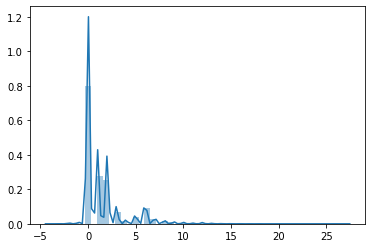

In [65]:
sns.distplot(y_train.flatten())

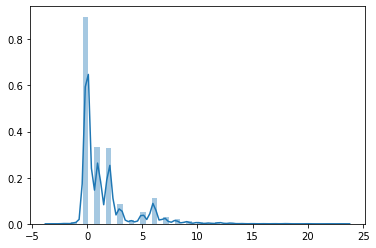

In [66]:
sns.distplot(y_dev.flatten())

True split after filtering:

In [67]:
total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]
print(f"Proportion training: {X_train.shape[0]/total_examples}")
print(f"Proportion dev: {X_dev.shape[0]/total_examples}")
print(f"Proportion test: {X_test.shape[0]/total_examples}")

Proportion training: 0.820683520330569
Proportion dev: 0.0990774484203277
Proportion test: 0.08023903124910327


In [68]:
def create_model(n_inputs):
    X_input = Input(shape=(N_STEPS_IN, n_inputs,))
    
    X = LSTM(30, return_sequences=False)(X_input)
    X = Dropout(rate=0.2)(X)
    
    output = Dense(N_STEPS_OUT, kernel_initializer=initializers.glorot_normal())(X)
    
    model = Model(inputs=X_input, outputs=output, name='new_lstm')
    
    # Compile
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [84]:
lstm_model = create_model(X_train.shape[2])

In [85]:
lstm_model.summary()

Model: "new_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 60)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                10920     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 155       
Total params: 11,075
Trainable params: 11,075
Non-trainable params: 0
_________________________________________________________________


In [86]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)

lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=256, 
    epochs=500, 
    validation_data=(
        X_dev, 
        y_dev
    ),
    callbacks=[es]
)

Train on 114400 samples, validate on 13811 samples
Epoch 1/500
114400/114400 [==============================] - 3s 23us/step - loss: 5.3730 - val_loss: 5.0691
Epoch 2/500
114400/114400 [==============================] - 2s 20us/step - loss: 4.3868 - val_loss: 4.9292
Epoch 3/500
114400/114400 [==============================] - 2s 21us/step - loss: 4.2968 - val_loss: 4.8526
Epoch 4/500
114400/114400 [==============================] - 2s 20us/step - loss: 4.2497 - val_loss: 4.8041
Epoch 5/500
114400/114400 [==============================] - 2s 20us/step - loss: 4.2154 - val_loss: 4.7598
Epoch 6/500
114400/114400 [==============================] - 2s 19us/step - loss: 4.1901 - val_loss: 4.7353
Epoch 7/500
114400/114400 [==============================] - 2s 20us/step - loss: 4.1764 - val_loss: 4.7229
Epoch 8/500
114400/114400 [==============================] - 2s 20us/step - loss: 4.1638 - val_loss: 4.7053
Epoch 9/500
114400/114400 [==============================] - 2s 19us/step - loss: 4.1

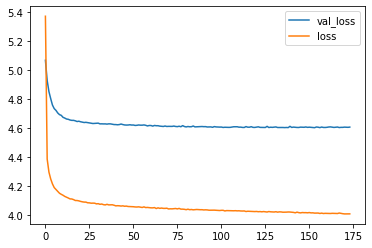

In [95]:
pd.DataFrame(lstm_model.history.history).plot()

### Permutation feature importance

In [98]:
model_error = mean_squared_error(y_train, lstm_model.predict(X_train))

In [99]:
def calculate_pfi(X, fitted_model, model_error, num_trials, feature_list):

    pfi_dict = {}

    for i, feature in enumerate(feature_list):
        print(feature, f'({i+1}/{len(feature_list)})')

        X_train_copy = np.copy(X)

        pfi_trials = []
        for trial in range(num_trials):

            feature_array = X_train_copy[:, :, i]
            num_rows, num_cols = feature_array.shape

            shuffled_flattened = feature_array.flatten()

            np.random.shuffle(shuffled_flattened)  # shuffles in-place

            shuffled_array = shuffled_flattened.reshape(num_rows, num_cols)

            X_train_copy[:, :, i] = shuffled_array

            predictions_shuffled = fitted_model.predict(X_train_copy)

            model_error_perm = mean_squared_error(y_train, predictions_shuffled)

            pfi = model_error_perm / model_error

            pfi_trials.append(pfi)

        mean_pfi = np.mean(pfi_trials)
        std_pfi = np.std(pfi_trials)

        pfi_dict[feature] = {'mean': mean_pfi, 'std': std_pfi}
    
    return pfi_dict

In [100]:
pfi_dict = calculate_pfi(X_train, model_error=model_error, fitted_model=lstm_model, num_trials=1, feature_list=COLUMNS_TO_SCALE)

Aerial Duels - Won - Percentage (1/60)
Assists (2/60)
Bad Touches (3/60)
Big Chances Created (4/60)
Caught Offside (5/60)
Chances From Counter Attack (6/60)
Clean Sheets (7/60)
Crosses - Open Play - Successful (8/60)
Crosses - Unsuccessful (9/60)
Distribution - Successful (10/60)
Dribbles - Successful Percentage (11/60)
Fouls (12/60)
Goals (13/60)
Goals Conceded (14/60)
Handballs (15/60)
ICT Creativity (16/60)
ICT Index (17/60)
Minutes Per Block (18/60)
Minutes Per Interception (19/60)
Minutes Per Save (20/60)
Minutes Per Tackle Won (21/60)
Minutes Per Touch (22/60)
xGI Expected Goal Involvement (23/60)
Pass Completion (24/60)
Pass Completion - Final Third (25/60)
Pass Completion - Opponents Half (26/60)
Passes - Backward (27/60)
Passes - Forward (28/60)
Premier League Straight Red Cards (29/60)
Premier League Total Red Cards (30/60)
Recoveries (31/60)
Saves (Shots Outside Box) (32/60)
Shot Accuracy (33/60)
Shots Blocked (34/60)
Shots On Target (35/60)
Subbed Off (36/60)
Subbed On (37/

In [102]:
pfi_df = pd.DataFrame(pfi_dict).T
pfi_df.sort_values('mean', ascending=False, inplace=True)
pfi_df.head()

,mean,std
Time Played,1.053640,0.0
position_DEF,1.011654,0.0
Touches - Final Third,1.011188,0.0
Pass Completion - Opponents Half,1.010579,0.0
position_MID,1.009622,0.0


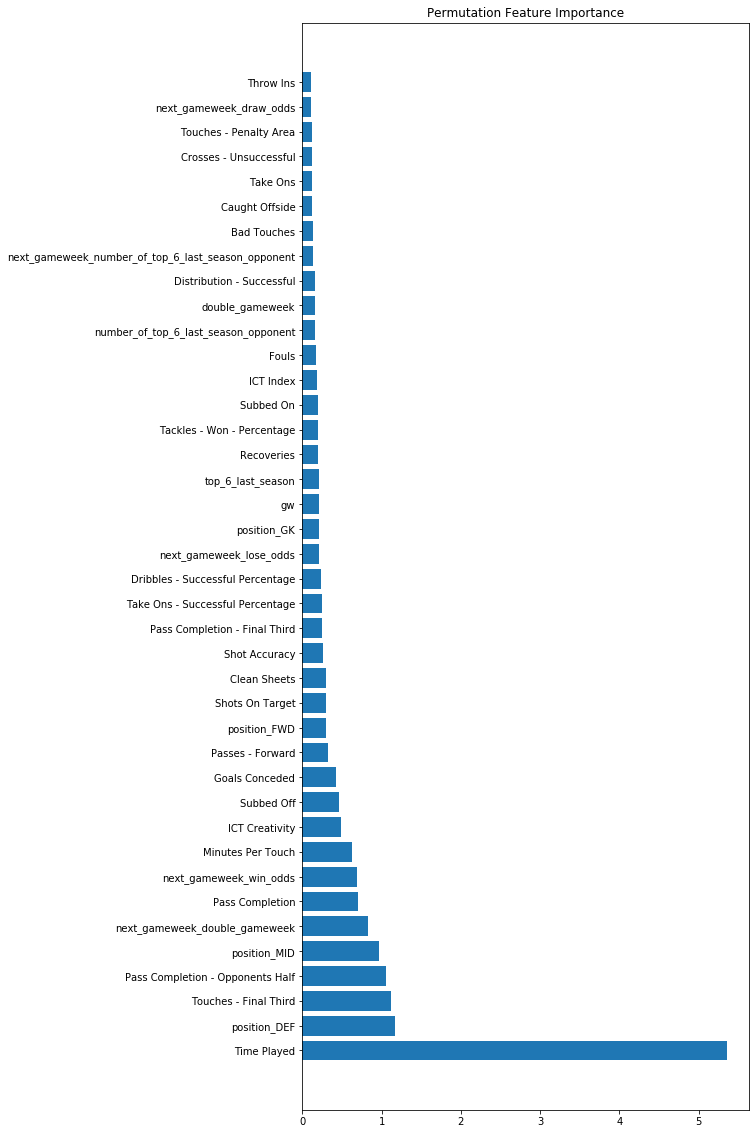

In [103]:
plt.figure(figsize=(8, 20))
plt.barh(
    pfi_df.head(40).index, 
    (pfi_df.head(40)['mean'] - 1) * 100
)
plt.title('Permutation Feature Importance')
plt.show()

## Save model

MMS

In [105]:
pickle.dump(
    mms,
    open('src/models/pickles/min_max_scalar_DeepFantasyFootball_v02.pickle', 'wb')
)

Model

In [106]:
lstm_model.save("src/models/pickles/DeepFantasyFootball_v02.h5")